In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

from torchvision.transforms import v2
from torchvision import datasets
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomRotation(20),
    v2.RandomResizedCrop(224, antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(225, antialias=True),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [12]:
train_img_path = "./data/train"
valid_img_path = "./data/valid"
train_set = datasets.ImageFolder(train_img_path, transform=train_transforms)
valid_set = datasets.ImageFolder(valid_img_path, transform=test_transforms)

In [70]:
# from torch.utils.data.sampler import SubsetRandomSampler

# validation_size = 0.2

# n_train = len(train_set)
# indices = list(range(n_train))
# split_index = int(np.floor(n_train * validation_size))
# np.random.shuffle(indices)
# train_index, valid_index = indices[split_index:], indices[:split_index]

# train_sampler = SubsetRandomSampler(train_index)
# valid_sampler = SubsetRandomSampler(valid_index)

In [37]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=0, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, num_workers=0, shuffle=True)

In [14]:
idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}

In [17]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(2, 1, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

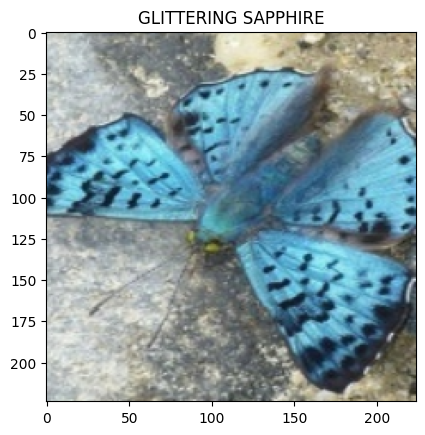

In [20]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

In [ ]:
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights

model = vgg19(weights=VGG19_Weights.DEFAULT, progress=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\navan/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:35<00:00, 16.3MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for param in model.parameters():
    param.requires_grad = False

ButterflyClassifier = torch.nn.Sequential(
    torch.nn.Linear(25088, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(2048, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(2048, 100),
    torch.nn.LogSoftmax(dim=1),
)

ButterflyClassifier

Sequential(
  (0): Linear(in_features=25088, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=2048, out_features=100, bias=True)
  (7): LogSoftmax(dim=1)
)

In [25]:
model.classifier = ButterflyClassifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [28]:
checkpoint_path = "./checkpoint.pt"

checkpoint = {"valid_loss_min": np.inf, "state_dict": None}
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    print("Checkpoint Loaded")

checkpoint

Checkpoint Loaded


{'valid_loss_min': 0.4451899515266346,
 'state_dict': OrderedDict([('features.0.weight',
               tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
                         [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
                         [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],
               
                        [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
                         [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
                         [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],
               
                        [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
                         [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
                         [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],
               
               
                       [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
                         [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
                         [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],
               
                        [[ 2.8746e

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [38]:
criterion = torch.nn.NLLLoss()
epochs = 50
learn_rate = 0.0001
validate_every = 5

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [34]:
# validation_loss_min = 3.3355438360353795 # np.Inf
validation_loss_min = checkpoint["valid_loss_min"]
model.to(device)

for e in range(epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  for images, labels in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    with torch.no_grad():
      model.eval()

      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

    model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    if validation_loss <= validation_loss_min:
      checkpoint = {"valid_loss_min": validation_loss, "state_dict": model.state_dict()}
      torch.save(checkpoint, checkpoint_path)
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")
      validation_loss_min = validation_loss


EPOCH 1:


100%|██████████| 394/394 [04:35<00:00,  1.43it/s]


Epoch 1 :: Running Loss: 5.04589330605444
EPOCH 2:


100%|██████████| 394/394 [03:25<00:00,  1.91it/s]


Epoch 2 :: Running Loss: 4.942705258500152
EPOCH 3:


100%|██████████| 394/394 [03:28<00:00,  1.89it/s]


Epoch 3 :: Running Loss: 4.774545191508259
EPOCH 4:


100%|██████████| 394/394 [02:21<00:00,  2.78it/s]


Epoch 4 :: Running Loss: 5.172267193721636
EPOCH 5:


100%|██████████| 394/394 [02:21<00:00,  2.78it/s]


Epoch 5 :: Running Loss: 4.654162036585928
EPOCH 5:
Running Loss = 4.654162036585928	Validation Loss: 4.641606068248071
EPOCH 6:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 6 :: Running Loss: 4.659002443255507
EPOCH 7:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 7 :: Running Loss: 4.781951955127232
EPOCH 8:


100%|██████████| 394/394 [02:19<00:00,  2.83it/s]


Epoch 8 :: Running Loss: 4.676683897899492
EPOCH 9:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 9 :: Running Loss: 4.650234747659131
EPOCH 10:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 10 :: Running Loss: 5.118019068906755
EPOCH 10:
Running Loss = 5.118019068906755	Validation Loss: 5.121443465276418
EPOCH 11:


100%|██████████| 394/394 [02:19<00:00,  2.83it/s]


Epoch 11 :: Running Loss: 5.014031140332294
EPOCH 12:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 12 :: Running Loss: 4.751458689646068
EPOCH 13:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 13 :: Running Loss: 4.605681752190372
EPOCH 14:


100%|██████████| 394/394 [02:19<00:00,  2.83it/s]


Epoch 14 :: Running Loss: 4.609635593927451
EPOCH 15:


100%|██████████| 394/394 [02:22<00:00,  2.76it/s]


Epoch 15 :: Running Loss: 4.631955728918163
EPOCH 15:
Running Loss = 4.631955728918163	Validation Loss: 4.620278801409726
EPOCH 16:


100%|██████████| 394/394 [02:22<00:00,  2.76it/s]


Epoch 16 :: Running Loss: 4.606971139230099
EPOCH 17:


100%|██████████| 394/394 [02:22<00:00,  2.77it/s]


Epoch 17 :: Running Loss: 5.786600574018991
EPOCH 18:


100%|██████████| 394/394 [02:21<00:00,  2.78it/s]


Epoch 18 :: Running Loss: 4.621077748119529
EPOCH 19:


100%|██████████| 394/394 [02:21<00:00,  2.78it/s]


Epoch 19 :: Running Loss: 4.98677966437364
EPOCH 20:


100%|██████████| 394/394 [02:19<00:00,  2.83it/s]


Epoch 20 :: Running Loss: 4.858739426898472
EPOCH 20:
Running Loss = 4.858739426898472	Validation Loss: 4.629184915329599
EPOCH 21:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 21 :: Running Loss: 4.604711294174194
EPOCH 22:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 22 :: Running Loss: 4.983296733217191
EPOCH 23:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 23 :: Running Loss: 4.6135201575187255
EPOCH 24:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 24 :: Running Loss: 4.994899960338767
EPOCH 25:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 25 :: Running Loss: 4.710160104151305
EPOCH 25:
Running Loss = 4.710160104151305	Validation Loss: 4.600808430444165
EPOCH 26:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 26 :: Running Loss: 4.608890287767207
EPOCH 27:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 27 :: Running Loss: 4.6149159603312535
EPOCH 28:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 28 :: Running Loss: 4.863425193099201
EPOCH 29:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 29 :: Running Loss: 4.6043343483494015
EPOCH 30:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 30 :: Running Loss: 4.6262573978017425
EPOCH 30:
Running Loss = 4.6262573978017425	Validation Loss: 4.599454232278815
EPOCH 31:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 31 :: Running Loss: 4.605158263656693
EPOCH 32:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 32 :: Running Loss: 4.604412864307462
EPOCH 33:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 33 :: Running Loss: 4.772523640376057
EPOCH 34:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 34 :: Running Loss: 4.604637217400643
EPOCH 35:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 35 :: Running Loss: 4.604933179574569
EPOCH 35:
Running Loss = 4.604933179574569	Validation Loss: 4.604321307942347
EPOCH 36:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 36 :: Running Loss: 4.604860868550799
EPOCH 37:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 37 :: Running Loss: 4.604651097718834
EPOCH 38:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 38 :: Running Loss: 4.652647214492566
EPOCH 39:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 39 :: Running Loss: 4.623895691130972
EPOCH 40:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 40 :: Running Loss: 4.604920231146256
EPOCH 40:
Running Loss = 4.604920231146256	Validation Loss: 4.599134963175972
EPOCH 41:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 41 :: Running Loss: 4.611832334305429
EPOCH 42:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 42 :: Running Loss: 4.605447471444377
EPOCH 43:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 43 :: Running Loss: 4.605135266550906
EPOCH 44:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 44 :: Running Loss: 4.604818987967399
EPOCH 45:


100%|██████████| 394/394 [02:18<00:00,  2.84it/s]


Epoch 45 :: Running Loss: 4.619546021301734
EPOCH 45:
Running Loss = 4.619546021301734	Validation Loss: 4.599696385678906
EPOCH 46:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 46 :: Running Loss: 4.6242049502842315
EPOCH 47:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 47 :: Running Loss: 4.604601070965607
EPOCH 48:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 48 :: Running Loss: 4.604411197797901
EPOCH 49:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 49 :: Running Loss: 4.6047626885060735
EPOCH 50:


100%|██████████| 394/394 [02:18<00:00,  2.85it/s]


Epoch 50 :: Running Loss: 4.839016277777967
EPOCH 50:
Running Loss = 4.839016277777967	Validation Loss: 4.599641471949931


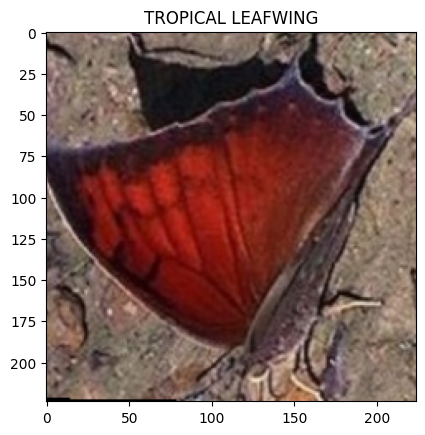

In [24]:
# Forward Pass for one image
images, labels = next(iter(valid_loader))
images = images.to(device)
labels = labels.to(device)
model.to(device)

display_image(images[0], idx_to_class[labels[0].item()])

In [45]:
best_checkpoint = torch.load(checkpoint_path)
model.load_state_dict(best_checkpoint["state_dict"])

<All keys matched successfully>

In [46]:
model.eval()
output = torch.exp(model.forward(images))
model.train()

print(output)
print(output[0])
print(max(output[0]))
pred_index = 22
print(f"Predicted = {idx_to_class[pred_index]}")
print(f"Confidence of class {labels[0].item()}: {output[0][labels[0].item()]}")
print(f"Label = {idx_to_class[labels[0].item()]} (Index: {labels[0].item()})")

tensor([[6.1449e-11, 4.4035e-11, 3.6374e-07,  ..., 5.9914e-09, 5.3505e-13,
         6.5667e-12],
        [7.4456e-04, 1.7586e-02, 1.5056e-04,  ..., 7.2910e-04, 2.2469e-04,
         2.3857e-03],
        [6.8418e-07, 2.2503e-08, 1.9258e-03,  ..., 3.6324e-05, 1.6599e-06,
         2.9925e-05],
        ...,
        [1.8758e-08, 2.1229e-06, 6.5852e-06,  ..., 4.7303e-07, 5.8088e-05,
         1.8685e-09],
        [7.5471e-07, 2.0722e-10, 6.2927e-11,  ..., 5.1700e-10, 3.5548e-07,
         1.7172e-07],
        [2.4655e-12, 1.7466e-13, 4.6918e-15,  ..., 8.5332e-14, 2.3044e-10,
         5.5109e-12]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([6.1449e-11, 4.4035e-11, 3.6374e-07, 1.0842e-10, 1.8780e-08, 9.9854e-01,
        8.8132e-11, 6.2945e-06, 2.4177e-10, 2.7072e-11, 6.6721e-06, 1.8849e-11,
        1.6450e-08, 2.9215e-11, 5.1690e-08, 4.2499e-09, 7.0232e-11, 3.0508e-10,
        7.2585e-11, 5.7674e-12, 3.9422e-12, 9.2526e-12, 7.1333e-10, 2.4243e-11,
        8.7040e-10, 1.0406e-07, 1.1033e-10,

100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Validation Accuracy: 92.20%


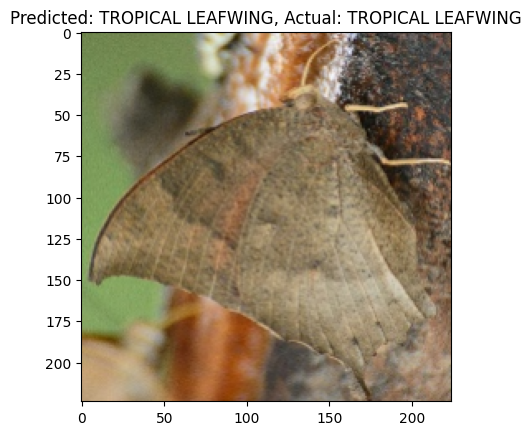

In [47]:
# Function to calculate accuracy
def test_accuracy(model, valid_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    model.train()

test_accuracy(model, valid_loader, device)

# Display a sample prediction
images, labels = next(iter(valid_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)
preds = torch.argmax(output, dim=1)

# Show the first image and its predicted label
display_image(images[0], f'Predicted: {idx_to_class[preds[0].item()]}, Actual: {idx_to_class[labels[0].item()]}')

In [55]:
print("\n".join(train_set.classes))

ADONIS
AFRICAN GIANT SWALLOWTAIL
AMERICAN SNOOT
AN 88
APPOLLO
ARCIGERA FLOWER MOTH
ATALA
ATLAS MOTH
BANDED ORANGE HELICONIAN
BANDED PEACOCK
BANDED TIGER MOTH
BECKERS WHITE
BIRD CHERRY ERMINE MOTH
BLACK HAIRSTREAK
BLUE MORPHO
BLUE SPOTTED CROW
BROOKES BIRDWING
BROWN ARGUS
BROWN SIPROETA
CABBAGE WHITE
CAIRNS BIRDWING
CHALK HILL BLUE
CHECQUERED SKIPPER
CHESTNUT
CINNABAR MOTH
CLEARWING MOTH
CLEOPATRA
CLODIUS PARNASSIAN
CLOUDED SULPHUR
COMET MOTH
COMMON BANDED AWL
COMMON WOOD-NYMPH
COPPER TAIL
CRECENT
CRIMSON PATCH
DANAID EGGFLY
EASTERN COMA
EASTERN DAPPLE WHITE
EASTERN PINE ELFIN
ELBOWED PIERROT
EMPEROR GUM MOTH
GARDEN TIGER MOTH
GIANT LEOPARD MOTH
GLITTERING SAPPHIRE
GOLD BANDED
GREAT EGGFLY
GREAT JAY
GREEN CELLED CATTLEHEART
GREEN HAIRSTREAK
GREY HAIRSTREAK
HERCULES MOTH
HUMMING BIRD HAWK MOTH
INDRA SWALLOW
IO MOTH
Iphiclus sister
JULIA
LARGE MARBLE
LUNA MOTH
MADAGASCAN SUNSET MOTH
MALACHITE
MANGROVE SKIPPER
MESTRA
METALMARK
MILBERTS TORTOISESHELL
MONARCH
MOURNING CLOAK
OLEANDER HAWK MOT

In [71]:
# Ensure model is in evaluation mode
model.eval()

# Initialize storage for true and predicted labels
all_preds = []
all_labels = []
all_probs = []

# Disable gradient calculations for validation
with torch.no_grad():
    for inputs, labels in tqdm(valid_loader):  # Assuming valid_loader is correctly defined
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        probs = torch.exp(outputs)
        _, preds = torch.max(outputs, 1)  # Get class index with highest probability

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Class labels
class_names = list(idx_to_class.values())  # Ensure idx_to_class is properly defined


100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


In [72]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(120, 100))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [73]:
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.80      0.89         5
AFRICAN GIANT SWALLOWTAIL       0.83      1.00      0.91         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      0.80      0.89         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      0.80      0.89         5
        BANDED TIGER MOTH       0.67      0.80      0.73         5
            BECKERS WHITE       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.89         5
         BLACK HAIRSTREAK       1.00  

Text(0.5, 0, 'False Positive Rate')

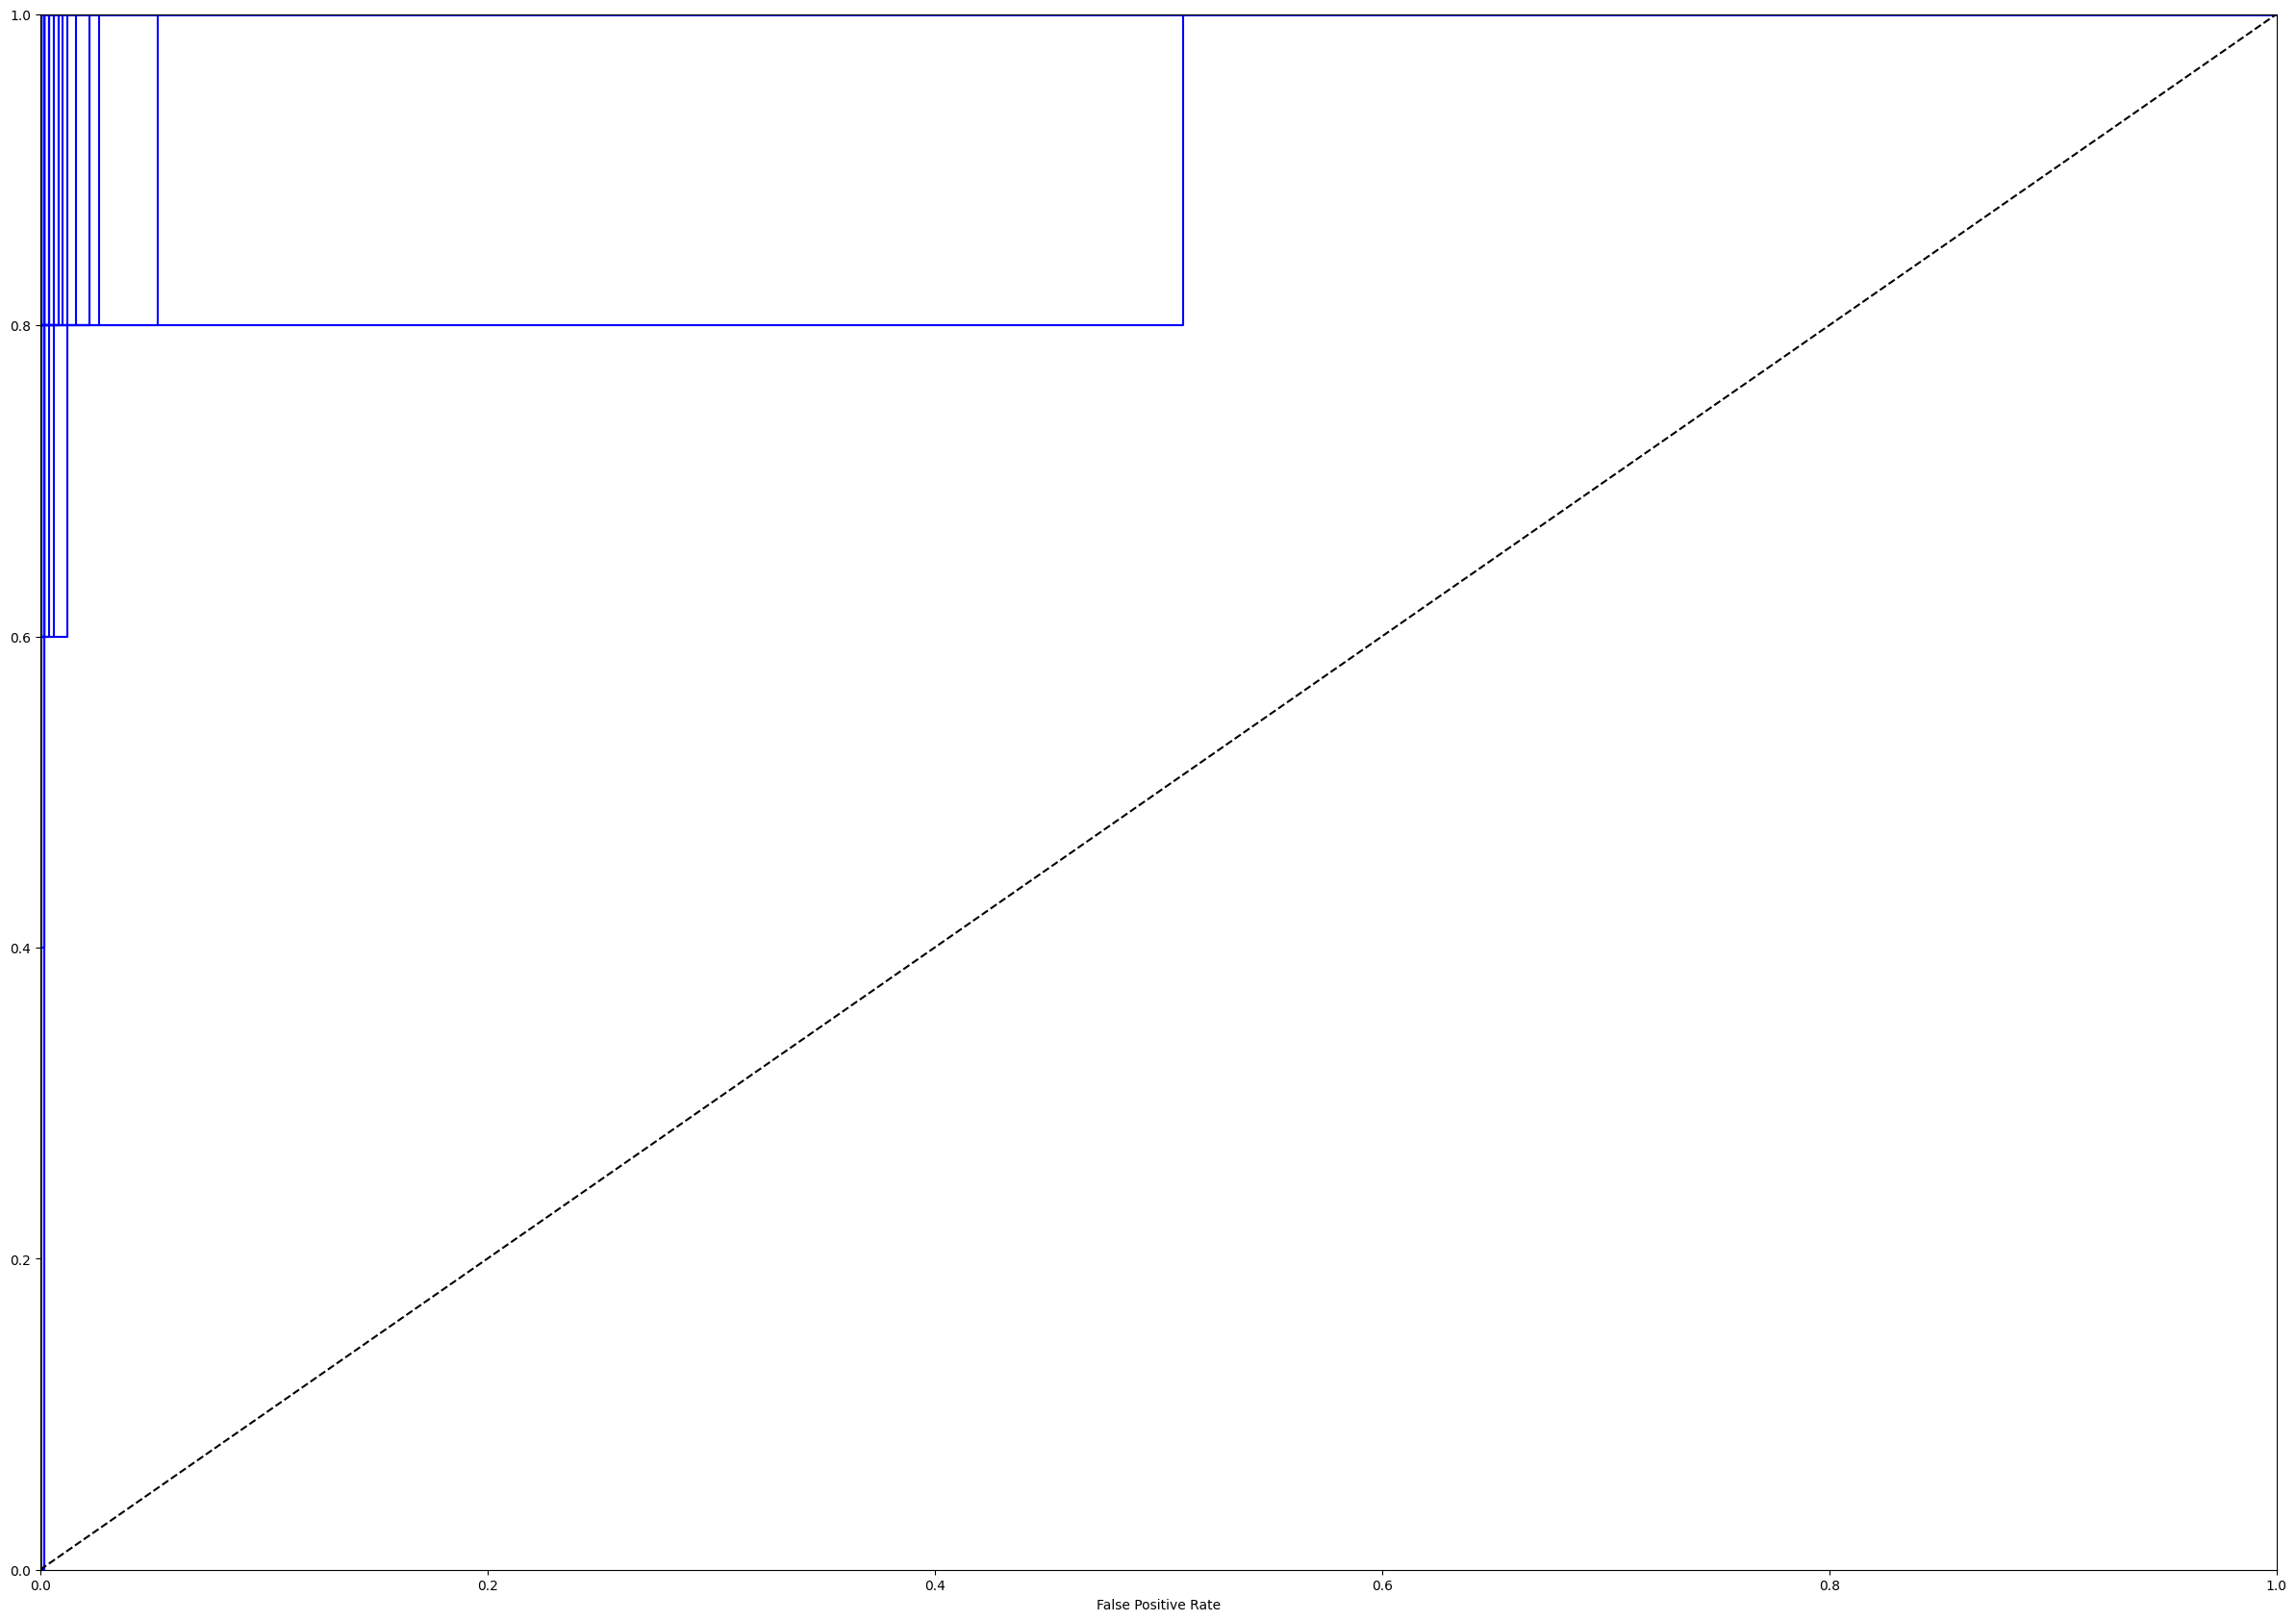

In [ ]:
# Plot ROC Curve (One vs Rest for Multi-class)
num_classes = len(class_names)
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))  # One-hot encode labels

plt.figure(figsize=(30, 21))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")